# KNN Direct Marketing

## Load Packages

In [4]:
import pandas as pd
import numpy as np
import group3lib
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

## Import Data

In [6]:
df = pd.read_csv('data/DirectMarketing.csv')

In [7]:
df.head()

,Age,Gender,OwnHome,Married,Location,Salary,Children,History,Catalogs,AmountSpent
0,Old,Female,Own,Single,Far,47500,0,High,6,755
1,Middle,Male,Rent,Single,Close,63600,0,High,6,1318
2,Young,Female,Rent,Single,Close,13500,0,Low,18,296
3,Middle,Male,Own,Married,Close,85600,1,High,18,2436
4,Middle,Female,Own,Single,Close,68400,0,High,12,1304


## Clean Data

In [8]:
def get_clean_df_labels(df):
    """Function takes original dataframe and returns cleaned data with labels. 
    Dataframe will encode categorical variables, normalize data, and bin the amount spent into low, medium, and high
    resulting in a labels column."""
    
    from sklearn.preprocessing import OneHotEncoder
    from sklearn import preprocessing
    
    #---ENCODE CATEGORIES---
    
    # creating instance of one-hot-encoder
    enc = OneHotEncoder(handle_unknown="ignore")

    # Age
    age = pd.DataFrame(enc.fit_transform(df[["Age"]]).toarray())
    age.columns = enc.get_feature_names(["Age"])

    # Gender
    gender = pd.DataFrame(enc.fit_transform(df[["Gender"]]).toarray())
    gender.columns = enc.get_feature_names(["Gender"])

    # OwnHome
    ownhome = pd.DataFrame(enc.fit_transform(df[["OwnHome"]]).toarray())
    ownhome.columns = enc.get_feature_names(["OwnHome"])

    # Married
    married = pd.DataFrame(enc.fit_transform(df[["Married"]]).toarray())
    married.columns = enc.get_feature_names(["Married"])

    # Location
    location = pd.DataFrame(enc.fit_transform(df[["Location"]]).toarray())
    location.columns = enc.get_feature_names(["Location"])
    
    # drop old columns
    df.drop(["Age", "Gender", "OwnHome", "Married", "Location", "History"], axis=1, inplace=True)

    # concat encoded columns
    df = pd.concat([df, age, gender, ownhome, married, location], axis=1)
    
    #---CREATE BINS---
    AmountSpent = pd.Series(df['AmountSpent'])

    # median
    lower_bound = AmountSpent.quantile(0.25)

    # 3rd Quantile
    middle_bound = AmountSpent.quantile(0.75)

    # infinity
    upper_bound = 999999999
    
    bins = [0, lower_bound, middle_bound, upper_bound]

    # low, medium, high
    names = [0, 1, 2]

    # create labels
    Spend_labels = pd.cut(AmountSpent, bins, right=False, labels=names)
    
    # drop amount spent from df
    df.drop(['AmountSpent'], axis=1, inplace=True)

    
    #---NORMALIZE DATA---
    
    # store the column names of df
    store_cols = df.columns

    # normalize data
    min_max_scaler=preprocessing.MinMaxScaler()
    data_scaled = min_max_scaler.fit_transform(df)
    DirectMarketingScaled = pd.DataFrame(data_scaled, columns=store_cols)

    # concat the df and labels
    DirectMarketing_Cln_Labels = pd.concat([DirectMarketingScaled, Spend_labels], axis = 1)
    
    return DirectMarketing_Cln_Labels

In [9]:
DirectMarketing_Cln_Labels = get_clean_df_labels(df)

In [10]:
DirectMarketing_Cln_Labels

,Salary,Children,Catalogs,Age_Middle,Age_Old,Age_Young,Gender_Female,Gender_Male,OwnHome_Own,OwnHome_Rent,Married_Married,Married_Single,Location_Close,Location_Far,AmountSpent
0,0.235665,0.000000,0.000000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1
1,0.337114,0.000000,0.000000,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1
2,0.021424,0.000000,0.666667,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0
3,0.475740,0.333333,0.666667,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,2
4,0.367360,0.000000,0.333333,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.058601,0.333333,0.666667,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0
996,0.191556,0.333333,0.666667,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1
997,0.218652,0.000000,1.000000,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1
998,0.434152,0.666667,0.666667,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1


## Model 1 - KNN

### Optimal Values of K - Grid Search

In [11]:
from sklearn.model_selection import GridSearchCV

In [12]:
# assign inputs and target variable
X = DirectMarketing_Cln_Labels.iloc[:,0:-1]
y = DirectMarketing_Cln_Labels.iloc[:,-1]

In [13]:
# create grid search
knn_grid = GridSearchCV(estimator = KNeighborsClassifier(), 
                        param_grid={'n_neighbors': np.arange(1,20)}, cv=5)

In [14]:
# fit the model
knn_grid.fit(X,y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])})

In [15]:
# best params
knn_grid.best_params_

{'n_neighbors': 6}

### Train/Test

In [16]:
# split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

In [17]:
# run KNN on different values of K
train_accuracy = []
validation_accuracy = []
for k in range(1,10):
    knn_model1 = KNeighborsClassifier(n_neighbors=k)
    knn_model1.fit(X_train, y_train)
    train_accuracy.append(knn_model1.score(X_train, y_train))
    validation_accuracy.append(knn_model1.score(X_test, y_test))

In [18]:
frame = pd.DataFrame({'k':range(1,10), 'train_acc':train_accuracy, 'valid_acc':validation_accuracy})
frame

,k,train_acc,valid_acc
0,1,0.997333,0.636
1,2,0.872000,0.628
2,3,0.862667,0.640
3,4,0.838667,0.656
4,5,0.825333,0.664
5,6,0.809333,0.696
6,7,0.820000,0.672
7,8,0.808000,0.676
8,9,0.777333,0.664


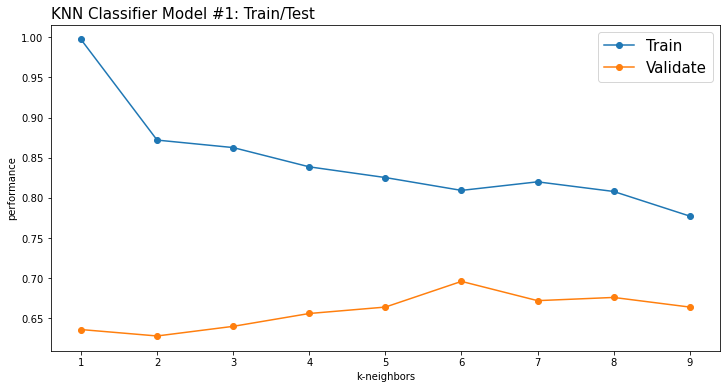

In [19]:
# plot differences

plt.figure(figsize=(12,6))
plt.plot(frame['k'], frame['train_acc'], marker='o', label='Train')
plt.plot(frame['k'], frame['valid_acc'], marker='o', label='Validate')
plt.xlabel('k-neighbors')
plt.ylabel('performance')
plt.title('KNN Classifier Model #1: Train/Test', fontsize = 15, loc='left')

plt.legend(prop={'size':15})
plt.show()

### Cross-Validation

In [20]:
# run KNN on different values of K
cv_scores_mean = []
for k in range(1,10):
    knn_model1_cv = KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(knn_model1_cv, X, y, cv=5)
    
    cv_scores_mean.append(np.mean(cv_scores))

In [21]:
cv_scores_mean

[0.7169999999999999, 0.698, 0.718, 0.72, 0.725, 0.736, 0.722, 0.72, 0.7]

In [22]:
frame_cv = pd.DataFrame({'k':range(1,10), 'cv_score': cv_scores_mean})
frame_cv

,k,cv_score
0,1,0.717
1,2,0.698
2,3,0.718
3,4,0.720
4,5,0.725
5,6,0.736
6,7,0.722
7,8,0.720
8,9,0.700


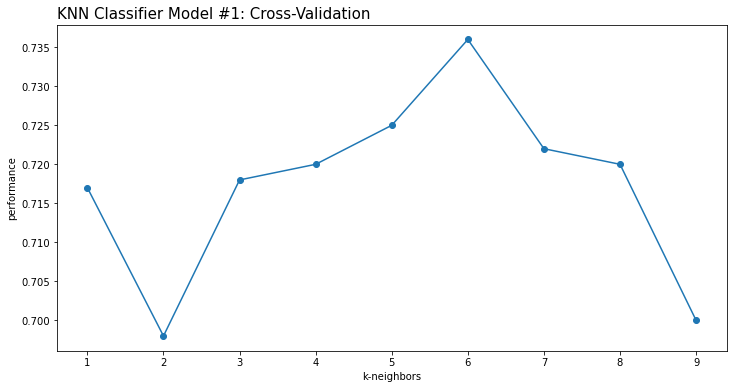

In [23]:
# plot cv scores

plt.figure(figsize=(12,6))
plt.plot(frame_cv['k'], frame_cv['cv_score'], marker='o')
plt.xlabel('k-neighbors')
plt.ylabel('performance')
plt.title('KNN Classifier Model #1: Cross-Validation', fontsize = 15, loc='left')

plt.show()

# Model # 2 : No Catalogs

In [24]:
# remove catalogs
no_catalogs = DirectMarketing_Cln_Labels.copy()
no_catalogs = no_catalogs.drop(['Catalogs'], axis=1)

In [25]:
# assign input data and target variable
X = no_catalogs.iloc[:,0:-1]
y = no_catalogs.iloc[:,-1]

### Optimal Values of K - Grid Search

In [26]:
# create grid search
knn_grid = GridSearchCV(estimator = KNeighborsClassifier(), 
                        param_grid={'n_neighbors': np.arange(1,20)}, cv=5)

In [27]:
# fit the model
knn_grid.fit(X,y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])})

In [28]:
# best params
knn_grid.best_params_

{'n_neighbors': 4}

### Train/Test

In [29]:
# split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

In [26]:
train_accuracy = []
validation_accuracy = []
for k in range(1,10):
    knn_model2 = KNeighborsClassifier(n_neighbors=k)
    knn_model2.fit(X_train, y_train)
    train_accuracy.append(knn_model2.score(X_train, y_train))
    validation_accuracy.append(knn_model2.score(X_test, y_test))

In [27]:
frame2 = pd.DataFrame({'k':range(1,10), 'train_acc':train_accuracy, 'valid_acc':validation_accuracy})
frame2

,k,train_acc,valid_acc
0,1,0.990667,0.644
1,2,0.846667,0.660
2,3,0.852000,0.672
3,4,0.830667,0.688
4,5,0.822667,0.664
5,6,0.801333,0.668
6,7,0.802667,0.656
7,8,0.793333,0.688
8,9,0.786667,0.668


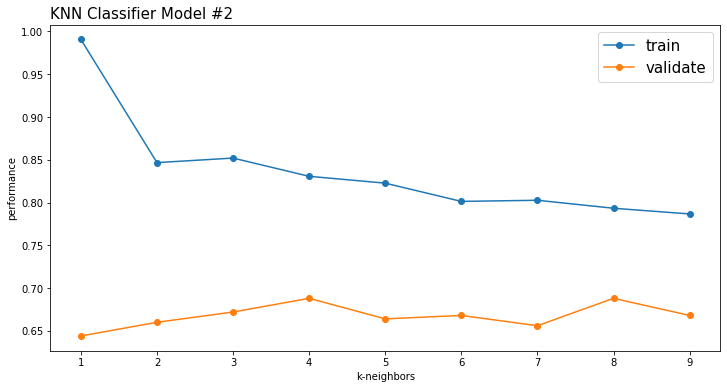

In [28]:
# plot differences

plt.figure(figsize=(12,6))
plt.plot(frame2['k'], frame2['train_acc'], marker='o', label='train')
plt.plot(frame2['k'], frame2['valid_acc'], marker='o', label='validate')
plt.xlabel('k-neighbors')
plt.ylabel('performance')
plt.title('KNN Classifier Model #2', fontsize = 15, loc='left')

plt.legend(prop={'size':15})
plt.show()

### Cross-Validation

In [29]:
# run KNN on different values of K
cv_scores_mean2 = []
for k in range(1,10):
    knn_model2_cv = KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(knn_model2_cv, X, y, cv=5)
    
    cv_scores_mean2.append(np.mean(cv_scores))

In [30]:
cv_scores_mean2

[0.701,
 0.6990000000000001,
 0.715,
 0.7310000000000001,
 0.718,
 0.724,
 0.708,
 0.704,
 0.7050000000000001]

In [31]:
frame_cv2 = pd.DataFrame({'k':range(1,10), 'cv_score': cv_scores_mean2})
frame_cv2

,k,cv_score
0,1,0.701
1,2,0.699
2,3,0.715
3,4,0.731
4,5,0.718
5,6,0.724
6,7,0.708
7,8,0.704
8,9,0.705


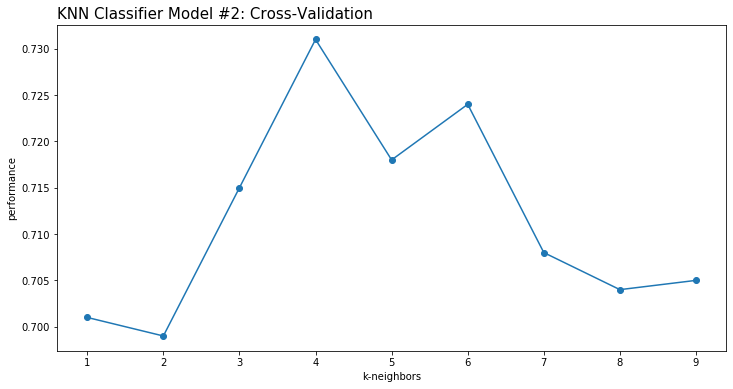

In [32]:
# plot cv scores

plt.figure(figsize=(12,6))
plt.plot(frame_cv2['k'], frame_cv2['cv_score'], marker='o')
plt.xlabel('k-neighbors')
plt.ylabel('performance')
plt.title('KNN Classifier Model #2: Cross-Validation', fontsize = 15, loc='left')

plt.show()